<a href="https://colab.research.google.com/github/naufalkr/DL-learn/blob/main/Multivariate_Time_Series_Forecasting_LSTM%2C_GRU%2C_Vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Dataset


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/naufalkr/DL-learn/main/Datasets/satudata.kemendag.go.id20250312143416.csv")
df

,Tahun,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,HKD,AUD,CAD
0,2025,0,0,0,0,0,0,0,0,0,0,0,0
1,Januari,"16,259.00","10,523.63",0,0,"20,245.72",0,"17,938.99","12,045.96","3,701.14","2,086.94","10,117.19","11,276.50"
2,2024,0,0,0,0,0,0,0,0,0,0,0,0
3,Desember,"16,162.00","10,236.25",0,0,"20,332.61",0,"17,920.95","11,919.34","3,616.48","2,082.02","10,081.88","11,225.18"
4,November,"15,864.00","10,453.01",0,0,"20,067.98",0,"17,944.72","11,805.79","3,566.56","2,038.59","10,283.06","11,310.03"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2000,"9,595.00","8,357.30","4,556.63","4,044.04","14,299.45","1,358.60","5,859.55","5,539.05","2,525.01","5,318.53",460.26,"6,389.01"
315,1999,"7,100.00","6,947.09","3,654.56","3,243.45","11,494.92","1,089.64","4,449.88","4,260.43","1,868.42","4,622.12",369.15,"4,886.28"
316,1998,"8,025.00","7,000.49","4,776.93","4,239.64","13,335.97","1,424.27","5,806.82","4,835.80","2,111.82","4,923.36",482.45,"5,182.11"
317,1997,"4,650.00","3,578.31","2,597.77","2,305.87","7,708.79",776.35,"3,196.98","2,772.83","1,198.47","3,039.94",264.36,"3,246.87"


# EDA & Data Preprocessing




The following data pre-processing steps need to be done:

*   Convert numeric columns from string to float
*   Separate Tahun & Bulan from 'Tahun' feature.
*   Merge Tahun & Bulan into one column 'Time' and change to datetime type.
*   Remove DEM, NLG, and FRH because >93% of their values are 0.0
*   Remove Year <2000 rows













  
  
  

In [3]:
# Convert numeric columns from string to float
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].replace(",", "", regex=True).apply(pd.to_numeric, errors="coerce")
df.dtypes

,0
Tahun,object
USD,float64
JPY,float64
DEM,float64
NLG,float64
GBP,float64
FRH,float64
CHF,float64
SGD,float64
MYR,float64


In [4]:
df = df.drop(df.tail(5).index)

In [5]:
# Remove rows with all zeros in numeric columns, assign correct years, create a 'Time' column in datetime format (YYYY-MM for normal years and YYYY for ≤ 2000. ignore the date)

df_clean = df[~(df[numeric_cols] == 0).all(axis=1)].reset_index(drop=True)
df_clean.rename(columns={'Tahun': 'Bulan'}, inplace=True)

current_year = 2025
df_clean.insert(0, 'Tahun', None)

for i in range(len(df_clean)):
    if df_clean.loc[i, 'Bulan'] == 'Desember':
        current_year -= 1
    elif isinstance(df_clean.loc[i, 'Bulan'], (int, float)) and df_clean.loc[i, 'Bulan'] >= 1996:
        current_year = df_clean.loc[i, 'Bulan']
    df_clean.loc[i, 'Tahun'] = current_year

df_clean['Tahun'] = df_clean['Tahun'].astype(int)

months_mapping = {
    'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04', 'Mei': '05', 'Juni': '06',
    'Juli': '07', 'Agustus': '08', 'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'
}

df_clean['Bulan'] = df_clean['Bulan'].map(months_mapping)

df_clean['Time'] = df_clean.apply(
    lambda row: pd.NaT if row['Tahun'] <= 2000 else f"{row['Tahun']}-{row['Bulan']}", axis=1
)

df_clean['Time'] = pd.to_datetime(df_clean['Time'], format='%Y-%m', errors='coerce')

df_clean['Time'] = df_clean['Time'].fillna(df_clean['Tahun'].astype(str))

df_clean.drop(columns=['Tahun', 'Bulan'], inplace=True)
df_clean = df_clean[['Time'] + [col for col in df_clean.columns if col != 'Time']]

df_clean

,Time,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,HKD,AUD,CAD
0,2025-01-01,16259.0000,10523.6300,0.0000,0.0000,20245.7200,0.0000,17938.9900,12045.9600,3701.1400,2086.9400,10117.1900,11276.5000
1,2024-12-01,16162.0000,10236.2500,0.0000,0.0000,20332.6100,0.0000,17920.9500,11919.3400,3616.4800,2082.0200,10081.8800,11225.1800
2,2024-11-01,15864.0000,10453.0100,0.0000,0.0000,20067.9800,0.0000,17944.7200,11805.7900,3566.5600,2038.5900,10283.0600,11310.0300
3,2024-10-01,15732.0000,10259.8900,0.0000,0.0000,20464.9800,0.0000,18136.9800,11878.1400,3587.2900,2024.5400,10319.4100,11302.9400
4,2024-09-01,15138.0000,10566.4400,0.0000,0.0000,20237.2400,0.0000,17899.9800,11788.3500,3675.1900,1946.1000,10417.2200,11222.0700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,2001-05-01,11058.0000,9217.3300,4838.3800,4294.1000,15764.8600,1442.6100,6210.9800,6114.4700,2910.0000,1417.8200,5654.5200,7155.9100
285,2001-04-01,11675.0000,9420.6600,5320.8600,4722.3000,16745.4800,1586.4600,6767.7400,6421.9000,3072.3700,1496.9300,5947.8500,7569.8800
286,2001-03-01,10400.0000,8370.0000,4681.8200,4155.1500,14852.2700,1395.9300,6014.0000,5778.9100,2736.8500,1333.4900,5098.6200,6609.0700
287,2001-02-01,9835.0000,8452.9700,4610.0000,4091.4100,14179.6300,1374.5100,5856.4400,5646.7900,2588.1600,1260.9700,5153.0600,6432.7400


In [6]:
df_clean.dtypes

,0
Time,datetime64[ns]
USD,float64
JPY,float64
DEM,float64
NLG,float64
GBP,float64
FRH,float64
CHF,float64
SGD,float64
MYR,float64


In [7]:
# NULL Values Check
df_clean.isnull().sum()

,0
Time,0
USD,0
JPY,0
DEM,0
NLG,0
GBP,0
FRH,0
CHF,0
SGD,0
MYR,0


In [8]:
(df_clean == 0.0).mean() * 100

,0
Time,0.0000
USD,0.0000
JPY,0.0000
DEM,95.5017
NLG,95.5017
GBP,0.0000
FRH,95.5017
CHF,0.0000
SGD,0.0000
MYR,0.0000


In [9]:
# More than 93% of DEM, NLG, and FRH values are 0.0. we will drop these features
df_clean = df_clean.drop(columns=['DEM', 'NLG', 'FRH'])
df_clean

,Time,USD,JPY,GBP,CHF,SGD,MYR,HKD,AUD,CAD
0,2025-01-01,16259.0000,10523.6300,20245.7200,17938.9900,12045.9600,3701.1400,2086.9400,10117.1900,11276.5000
1,2024-12-01,16162.0000,10236.2500,20332.6100,17920.9500,11919.3400,3616.4800,2082.0200,10081.8800,11225.1800
2,2024-11-01,15864.0000,10453.0100,20067.9800,17944.7200,11805.7900,3566.5600,2038.5900,10283.0600,11310.0300
3,2024-10-01,15732.0000,10259.8900,20464.9800,18136.9800,11878.1400,3587.2900,2024.5400,10319.4100,11302.9400
4,2024-09-01,15138.0000,10566.4400,20237.2400,17899.9800,11788.3500,3675.1900,1946.1000,10417.2200,11222.0700
...,...,...,...,...,...,...,...,...,...,...
284,2001-05-01,11058.0000,9217.3300,15764.8600,6210.9800,6114.4700,2910.0000,1417.8200,5654.5200,7155.9100
285,2001-04-01,11675.0000,9420.6600,16745.4800,6767.7400,6421.9000,3072.3700,1496.9300,5947.8500,7569.8800
286,2001-03-01,10400.0000,8370.0000,14852.2700,6014.0000,5778.9100,2736.8500,1333.4900,5098.6200,6609.0700
287,2001-02-01,9835.0000,8452.9700,14179.6300,5856.4400,5646.7900,2588.1600,1260.9700,5153.0600,6432.7400


In [10]:
df_clean.shape

(289, 10)

## Statistical Normality Test
*   p <= alpha: reject H0, not normal.
*   p > alpha: fail to reject H0, normal.



In [11]:
stat, p = stats.normaltest(df_clean.CAD)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=24.082, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.5797162315890505
Skewness of normal distribution: -0.6224192564723566


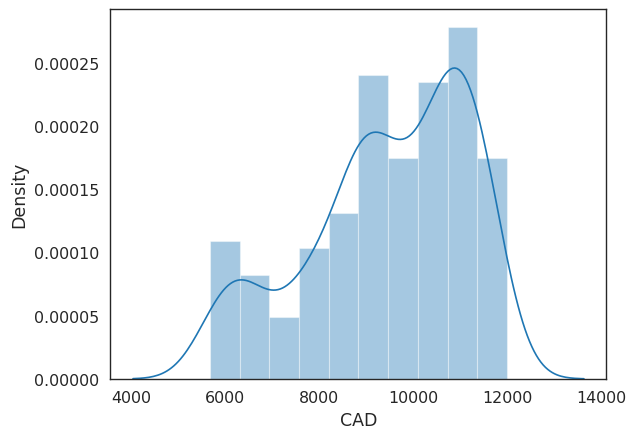

In [12]:
sns.distplot(df_clean.CAD);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_clean.CAD)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_clean.CAD)))

# Train Test Split


In [13]:
df_split = df_clean
df_split = df_split.sort_values(by="Time")

# Train test split based on Time
# Data training: Januari 2001 – Desember 2023, Data testing: Januari 2024 – Januari 2025
df_train = df_split[(df_split["Time"] >= "2001-01-01") & (df_split["Time"] <= "2023-12-31")]
df_test = df_split[(df_split["Time"] >= "2024-01-01") & (df_split["Time"] <= "2025-01-31")]

In [14]:
df_train

,Time,USD,JPY,GBP,CHF,SGD,MYR,HKD,AUD,CAD
288,2001-01-01,9450.0000,8131.4900,13814.9800,5743.6400,5416.1000,2486.8500,1211.6600,5167.7500,6284.5100
287,2001-02-01,9835.0000,8452.9700,14179.6300,5856.4400,5646.7900,2588.1600,1260.9700,5153.0600,6432.7400
286,2001-03-01,10400.0000,8370.0000,14852.2700,6014.0000,5778.9100,2736.8500,1333.4900,5098.6200,6609.0700
285,2001-04-01,11675.0000,9420.6600,16745.4800,6767.7400,6421.9000,3072.3700,1496.9300,5947.8500,7569.8800
284,2001-05-01,11058.0000,9217.3300,15764.8600,6210.9800,6114.4700,2910.0000,1417.8200,5654.5200,7155.9100
...,...,...,...,...,...,...,...,...,...,...
17,2023-08-01,15239.0000,10410.0000,19256.0000,17316.0000,11265.0000,3281.0000,1942.0000,9852.0000,11238.0000
16,2023-09-01,15526.0000,10420.0000,18861.0000,16942.0000,11334.0000,3300.0000,1985.0000,9906.0000,11484.0000
15,2023-10-01,15916.0000,10645.0900,19253.6000,17608.1700,11635.7900,3340.5500,2034.9100,10116.2200,11485.4800
14,2023-11-01,15384.0000,10442.2300,19541.5300,17528.6300,11554.3300,3306.2600,1972.7000,10201.9000,11341.8000


In [15]:
df_test

,Time,USD,JPY,GBP,CHF,SGD,MYR,HKD,AUD,CAD
12,2024-01-01,15796.0000,10723.0000,20057.0000,18346.0000,11796.0000,3341.0000,2021.0000,10447.0000,11782.0000
11,2024-02-01,15673.0000,10396.3400,19840.4700,17790.0400,11646.7500,3290.5800,2002.6200,10200.0100,11563.3900
10,2024-03-01,15853.0000,10450.5800,20021.5700,17508.4300,11765.6400,3350.8800,2026.3500,10345.6900,11659.6200
9,2024-04-01,16249.0000,10445.1600,20365.6900,17827.6400,11949.1300,3404.3700,2076.1300,10667.4800,11900.1100
8,2024-05-01,16253.0000,10353.2200,20655.9600,17860.4600,12022.8000,3452.9500,2079.0400,10741.6200,11846.6500
7,2024-06-01,16421.0000,10227.6500,20745.5000,18299.4600,12095.6300,3479.4100,2102.9300,10939.6900,11996.6500
6,2024-07-01,16320.0000,10540.2600,20972.0500,18410.5200,12144.2300,3532.8600,2089.3500,10692.0600,11784.6700
5,2024-08-01,15409.0000,10649.3000,20356.8700,18295.0500,11837.6200,3564.0300,1975.7300,10488.9200,11446.7200
4,2024-09-01,15138.0000,10566.4400,20237.2400,17899.9800,11788.3500,3675.1900,1946.1000,10417.2200,11222.0700
3,2024-10-01,15732.0000,10259.8900,20464.9800,18136.9800,11878.1400,3587.2900,2024.5400,10319.4100,11302.9400


In [16]:
df_train.shape

(276, 10)

In [17]:
df_test.shape

(13, 10)

In [18]:
# Data Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(df_train.drop(columns=['Time']))
scaled_test = scaler.transform(df_test.drop(columns=['Time']))

X_train = scaled_train[:, :-1]
y_train = scaled_train[:, -1]
X_test = scaled_test[:, :-1]
y_test = scaled_test[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### Window Size
Karena time series forecasting umumnya menggunakan window size, beberapa data tidak dapat diprediksi karena kurangnya input historis yang cukup (data testing hanya ada 13). Misalnya, dengan window size 6, prediksi pertama baru bisa dilakukan pada bulan ke-7, sehingga data testing dari Januari hingga Juni 2024 tidak dapat diprediksi, dan hanya data dari Juli 2024 ke depan yang bisa digunakan. Adapun jika kurang dari 6 (misal 2 atau 3), model akan hanya memeriksa sedikit history, sehingga hasil prediksi bisa jadi tidak relevan.

Sebagai alternatif, saya mencoba metode recursive forecasting, di mana setiap prediksi digunakan sebagai input untuk menghasilkan prediksi bulan berikutnya hingga Januari 2025. Namun, hasil prediksinya dan evaluation scorenya sangat berbeda dari data testing sebenarnya karena kesalahan yang terus menumpuk. Setiap prediksi bergantung pada prediksi sebelumnya, sehingga ketidakakuratan dari awal data semakin membesar seiring berjalannya waktu.

### Conclusion
Berdasarkan pertimbangan di atas, model tanpa window size atau memberikan hasil yang lebih stabil dan akurat dibandingkan model yang menggunakan window size atau recursive forecasting. Oleh karena itu, saya memutuskan untuk tidak menggunakan keduanya.

# LSTM
### Model Architecture
- The model consists of 50 neurons in the first hidden layer and 1 neuron in the output layer for exchange rate prediction. The input shape is adjusted based on the number of time steps and features in the data.
- Dropout 20%.
- The Mean Squared Error (MSE) loss function is used, along with the Adam optimizer for efficient training.
- The model is trained for 50 epochs with a batch size of 32 and validated using the test data.

In [31]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 - 2s - 250ms/step - loss: 0.3069 - val_loss: 0.4823
Epoch 2/50
9/9 - 0s - 12ms/step - loss: 0.1987 - val_loss: 0.2753
Epoch 3/50
9/9 - 0s - 12ms/step - loss: 0.1097 - val_loss: 0.1256
Epoch 4/50
9/9 - 0s - 12ms/step - loss: 0.0509 - val_loss: 0.0359
Epoch 5/50
9/9 - 0s - 13ms/step - loss: 0.0222 - val_loss: 0.0036
Epoch 6/50
9/9 - 0s - 12ms/step - loss: 0.0148 - val_loss: 0.0030
Epoch 7/50
9/9 - 0s - 15ms/step - loss: 0.0158 - val_loss: 0.0053
Epoch 8/50
9/9 - 0s - 13ms/step - loss: 0.0150 - val_loss: 0.0030
Epoch 9/50
9/9 - 0s - 16ms/step - loss: 0.0138 - val_loss: 0.0018
Epoch 10/50
9/9 - 0s - 12ms/step - loss: 0.0133 - val_loss: 0.0016
Epoch 11/50
9/9 - 0s - 12ms/step - loss: 0.0148 - val_loss: 0.0016
Epoch 12/50
9/9 - 0s - 12ms/step - loss: 0.0136 - val_loss: 0.0016
Epoch 13/50
9/9 - 0s - 12ms/step - loss: 0.0143 - val_loss: 0.0015
Epoch 14/50
9/9 - 0s - 12ms/step - loss: 0.0139 - val_loss: 0.0015
Epoch 15/50
9/9 - 0s - 16ms/step - loss: 0.0130 - val_loss: 0.0016
Epo

In [32]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[2]), train_predict), axis=1))[:, -1]
test_predict = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), test_predict), axis=1))[:, -1]
y_train_actual = scaler.inverse_transform(scaled_train)[:, -1]
y_test_actual = scaler.inverse_transform(scaled_test)[:, -1]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [33]:
# Evaluation metrics
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
train_rmse = np.sqrt(train_mse)
test_mae = mean_absolute_error(y_test_actual, test_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
test_rmse = np.sqrt(test_mse)

print("Evaluasi pada Data Training:")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print("\nEvaluasi pada Data Testing:")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")

Evaluasi pada Data Training:
MAE: 406.7899
MSE: 314727.1644
RMSE: 561.0055

Evaluasi pada Data Testing:
MAE: 234.6162
MSE: 68202.3103
RMSE: 261.1557


# GRU
### Model Architecture
- The model consists of 50 neurons in the first hidden layer and 1 neuron in the output layer for exchange rate prediction. The input shape is adjusted based on the number of time steps and features in the data.
- Dropout 20%.
- The Mean Squared Error (MSE) loss function is used, along with the Adam optimizer for efficient training.
- The model is trained for 50 epochs with a batch size of 32 and validated using the test data.

In [34]:
gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.summary()

gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 50)                  │           9,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,051 (35.36 KB)

 Trainable params: 9,051 (35.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 - 3s - 283ms/step - loss: 0.4584 - val_loss: 0.4902
Epoch 2/50
9/9 - 0s - 12ms/step - loss: 0.2038 - val_loss: 0.1457
Epoch 3/50
9/9 - 0s - 15ms/step - loss: 0.0708 - val_loss: 0.0140
Epoch 4/50
9/9 - 0s - 16ms/step - loss: 0.0214 - val_loss: 0.0054
Epoch 5/50
9/9 - 0s - 12ms/step - loss: 0.0209 - val_loss: 0.0189
Epoch 6/50
9/9 - 0s - 12ms/step - loss: 0.0229 - val_loss: 0.0142
Epoch 7/50
9/9 - 0s - 12ms/step - loss: 0.0204 - val_loss: 0.0064
Epoch 8/50
9/9 - 0s - 17ms/step - loss: 0.0215 - val_loss: 0.0035
Epoch 9/50
9/9 - 0s - 14ms/step - loss: 0.0190 - val_loss: 0.0028
Epoch 10/50
9/9 - 0s - 16ms/step - loss: 0.0176 - val_loss: 0.0026
Epoch 11/50
9/9 - 0s - 11ms/step - loss: 0.0179 - val_loss: 0.0029
Epoch 12/50
9/9 - 0s - 16ms/step - loss: 0.0185 - val_loss: 0.0025
Epoch 13/50
9/9 - 0s - 15ms/step - loss: 0.0179 - val_loss: 0.0026
Epoch 14/50
9/9 - 0s - 11ms/step - loss: 0.0187 - val_loss: 0.0019
Epoch 15/50
9/9 - 0s - 15ms/step - loss: 0.0183 - val_loss: 0.0020
Epo

In [35]:
gru_train_predict = gru_model.predict(X_train)
gru_test_predict = gru_model.predict(X_test)
gru_train_predict = scaler.inverse_transform(np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[2]), gru_train_predict), axis=1))[:, -1]
gru_test_predict = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), gru_test_predict), axis=1))[:, -1]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [36]:
# Evaluation metrics
gru_train_mae = mean_absolute_error(y_train_actual, gru_train_predict)
gru_train_mse = mean_squared_error(y_train_actual, gru_train_predict)
gru_train_rmse = np.sqrt(gru_train_mse)
gru_test_mae = mean_absolute_error(y_test_actual, gru_test_predict)
gru_test_mse = mean_squared_error(y_test_actual, gru_test_predict)
gru_test_rmse = np.sqrt(gru_test_mse)

print("Evaluasi pada Data Training GRU:")
print(f"MAE: {gru_train_mae:.4f}")
print(f"MSE: {gru_train_mse:.4f}")
print(f"RMSE: {gru_train_rmse:.4f}")
print("\nEvaluasi pada Data Testing GRU:")
print(f"MAE: {gru_test_mae:.4f}")
print(f"MSE: {gru_test_mse:.4f}")
print(f"RMSE: {gru_test_rmse:.4f}")

Evaluasi pada Data Training GRU:
MAE: 382.5075
MSE: 287148.6244
RMSE: 535.8625

Evaluasi pada Data Testing GRU:
MAE: 197.7612
MSE: 50927.0169
RMSE: 225.6702


# Vanilla RNN
### Model Architecture
- The model consists of 50 neurons in the first hidden layer and 1 neuron in the output layer for exchange rate prediction. The input shape is adjusted based on the number of time steps and features in the data.
- Dropout 20%.
- The Mean Squared Error (MSE) loss function is used, along with the Adam optimizer for efficient training.
- The model is trained for 50 epochs with a batch size of 32 and validated using the test data.

In [37]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.add(Dropout(0.2))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.summary()

rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           2,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001 (11.72 KB)

 Trainable params: 3,001 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 - 2s - 208ms/step - loss: 0.9719 - val_loss: 1.0330
Epoch 2/50
9/9 - 0s - 11ms/step - loss: 0.3704 - val_loss: 0.2624
Epoch 3/50
9/9 - 0s - 15ms/step - loss: 0.1242 - val_loss: 0.0259
Epoch 4/50
9/9 - 0s - 16ms/step - loss: 0.1430 - val_loss: 0.0028
Epoch 5/50
9/9 - 0s - 12ms/step - loss: 0.1137 - val_loss: 0.0045
Epoch 6/50
9/9 - 0s - 11ms/step - loss: 0.0999 - val_loss: 0.0200
Epoch 7/50
9/9 - 0s - 11ms/step - loss: 0.1022 - val_loss: 0.0381
Epoch 8/50
9/9 - 0s - 16ms/step - loss: 0.1013 - val_loss: 0.0410
Epoch 9/50
9/9 - 0s - 11ms/step - loss: 0.1128 - val_loss: 0.0325
Epoch 10/50
9/9 - 0s - 16ms/step - loss: 0.0935 - val_loss: 0.0257
Epoch 11/50
9/9 - 0s - 15ms/step - loss: 0.1087 - val_loss: 0.0248
Epoch 12/50
9/9 - 0s - 14ms/step - loss: 0.0939 - val_loss: 0.0267
Epoch 13/50
9/9 - 0s - 17ms/step - loss: 0.1145 - val_loss: 0.0280
Epoch 14/50
9/9 - 0s - 11ms/step - loss: 0.1085 - val_loss: 0.0278
Epoch 15/50
9/9 - 0s - 11ms/step - loss: 0.0860 - val_loss: 0.0254
Epo

In [38]:
rnn_train_predict = rnn_model.predict(X_train)
rnn_test_predict = rnn_model.predict(X_test)
rnn_train_predict = scaler.inverse_transform(np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[2]), rnn_train_predict), axis=1))[:, -1]
rnn_test_predict = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), rnn_test_predict), axis=1))[:, -1]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [39]:
rnn_train_mae = mean_absolute_error(y_train_actual, rnn_train_predict)
rnn_train_mse = mean_squared_error(y_train_actual, rnn_train_predict)
rnn_train_rmse = np.sqrt(rnn_train_mse)
rnn_test_mae = mean_absolute_error(y_test_actual, rnn_test_predict)
rnn_test_mse = mean_squared_error(y_test_actual, rnn_test_predict)
rnn_test_rmse = np.sqrt(rnn_test_mse)

print("Evaluasi pada Data Training Vanilla RNN:")
print(f"MAE: {rnn_train_mae:.4f}")
print(f"MSE: {rnn_train_mse:.4f}")
print(f"RMSE: {rnn_train_rmse:.4f}")
print("\nEvaluasi pada Data Testing Vanilla RNN:")
print(f"MAE: {rnn_test_mae:.4f}")
print(f"MSE: {rnn_test_mse:.4f}")
print(f"RMSE: {rnn_test_rmse:.4f}")

Evaluasi pada Data Training Vanilla RNN:
MAE: 855.6935
MSE: 926939.0764
RMSE: 962.7768

Evaluasi pada Data Testing Vanilla RNN:
MAE: 1209.3772
MSE: 1515165.9593
RMSE: 1230.9208


# Model Comparison

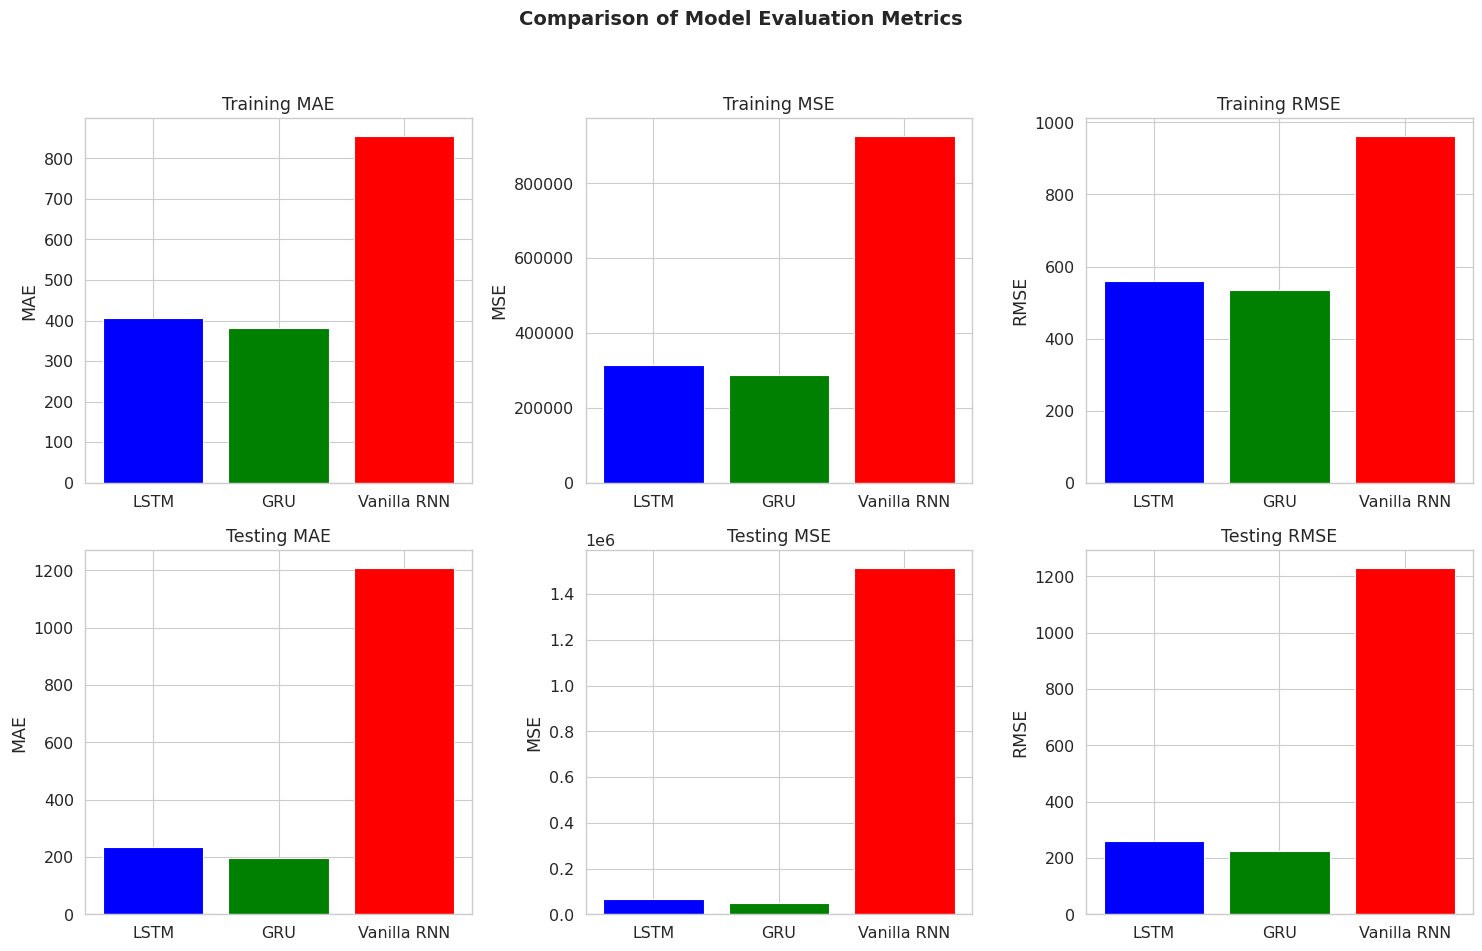

In [40]:
# Evaluation Metrics
models = ['LSTM', 'GRU', 'Vanilla RNN']
metrics = ['MAE', 'MSE', 'RMSE']

train_mae = [train_mae, gru_train_mae, rnn_train_mae]
train_mse = [train_mse, gru_train_mse, rnn_train_mse]
train_rmse = [train_rmse, gru_train_rmse, rnn_train_rmse]

test_mae = [test_mae, gru_test_mae, rnn_test_mae]
test_mse = [test_mse, gru_test_mse, rnn_test_mse]
test_rmse = [test_rmse, gru_test_rmse, rnn_test_rmse]

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparison of Model Evaluation Metrics", fontsize=14, fontweight='bold')

for i, (metric, train_values, test_values) in enumerate(zip(metrics,
                                                            [train_mae, train_mse, train_rmse],
                                                            [test_mae, test_mse, test_rmse])):
    axes[0, i].bar(models, train_values, color=['blue', 'green', 'red'])
    axes[0, i].set_title(f"Training {metric}")
    axes[0, i].set_ylabel(metric)

    axes[1, i].bar(models, test_values, color=['blue', 'green', 'red'])
    axes[1, i].set_title(f"Testing {metric}")
    axes[1, i].set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

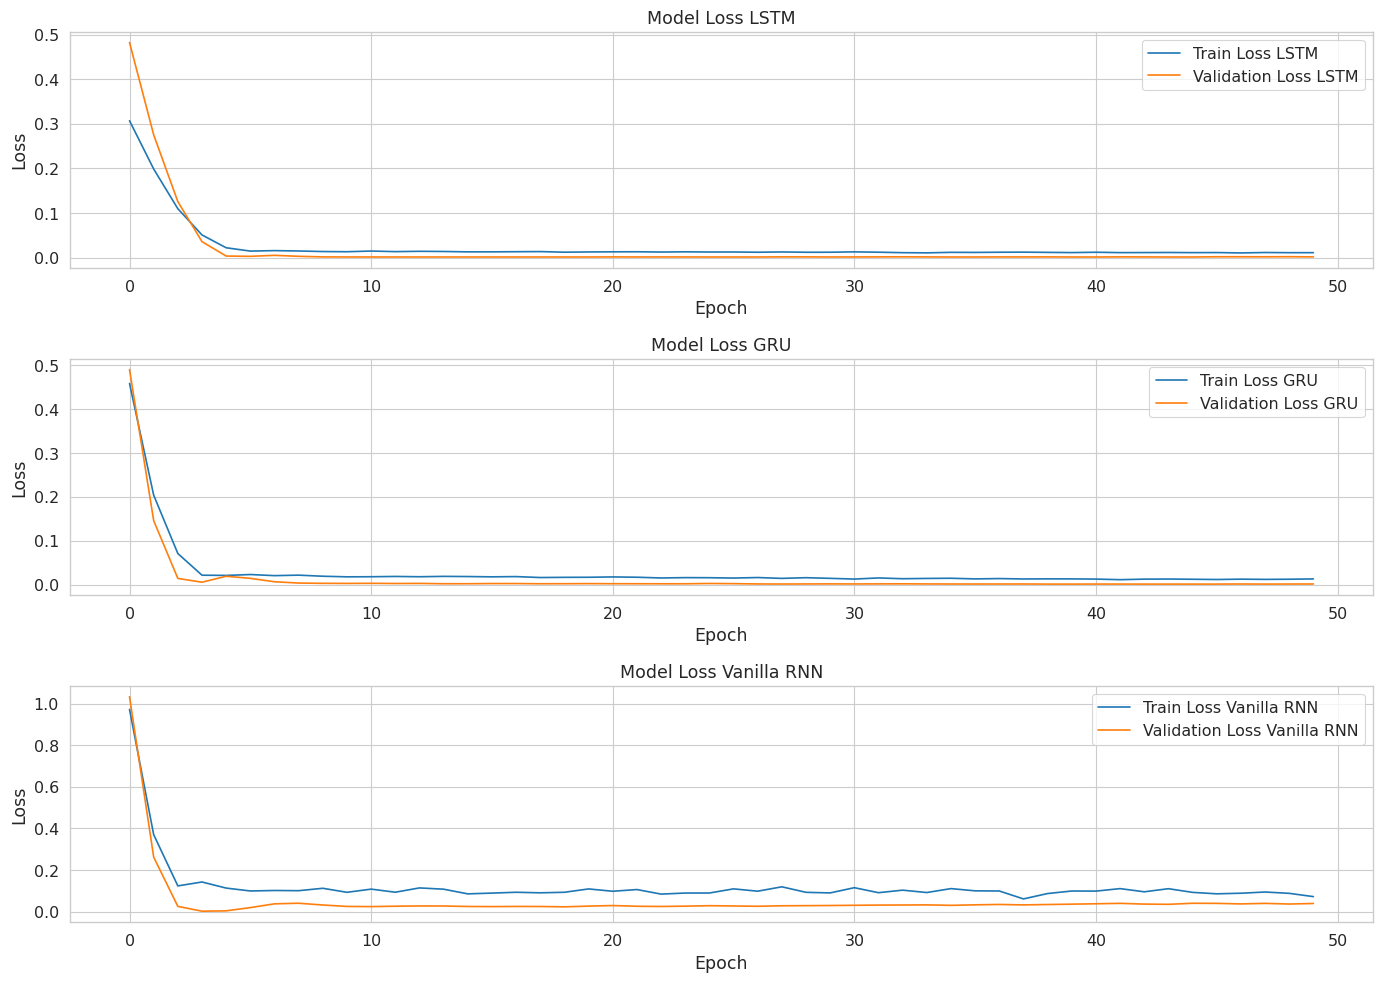

In [41]:
# Plot loss
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Train Loss LSTM')
plt.plot(history.history['val_loss'], label='Validation Loss LSTM')
plt.title('Model Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(gru_history.history['loss'], label='Train Loss GRU')
plt.plot(gru_history.history['val_loss'], label='Validation Loss GRU')
plt.title('Model Loss GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(rnn_history.history['loss'], label='Train Loss Vanilla RNN')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss Vanilla RNN')
plt.title('Model Loss Vanilla RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

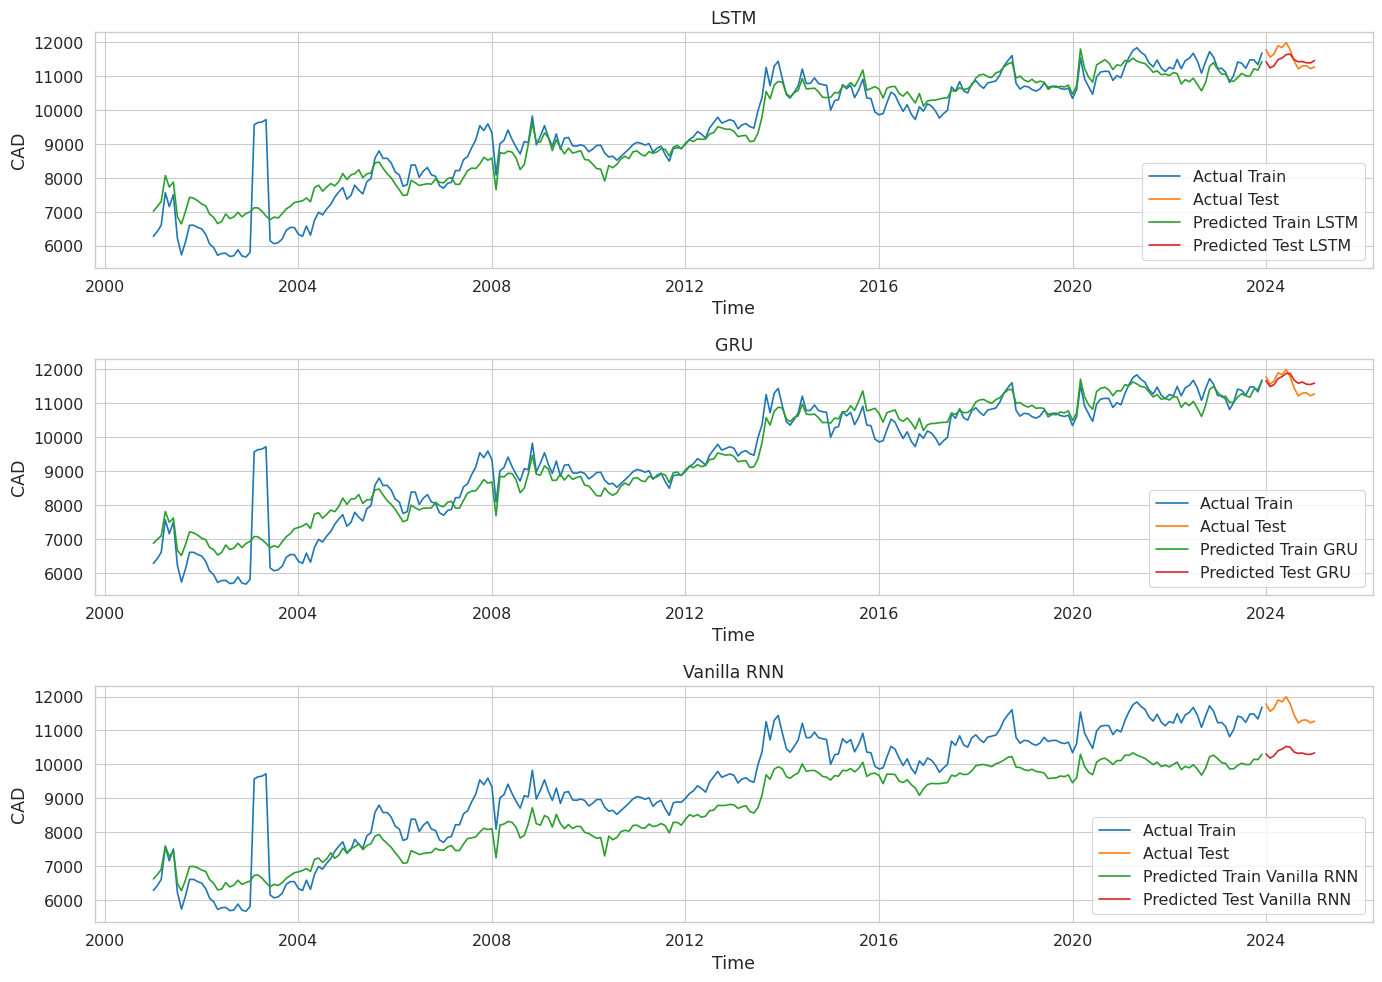

In [42]:
# Compare actual vs prediction
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(df_train['Time'], y_train_actual, label='Actual Train')
plt.plot(df_test['Time'], y_test_actual, label='Actual Test')
plt.plot(df_train['Time'], train_predict, label='Predicted Train LSTM')
plt.plot(df_test['Time'], test_predict, label='Predicted Test LSTM')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('CAD')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_train['Time'], y_train_actual, label='Actual Train')
plt.plot(df_test['Time'], y_test_actual, label='Actual Test')
plt.plot(df_train['Time'], gru_train_predict, label='Predicted Train GRU')
plt.plot(df_test['Time'], gru_test_predict, label='Predicted Test GRU')
plt.title('GRU')
plt.xlabel('Time')
plt.ylabel('CAD')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_train['Time'], y_train_actual, label='Actual Train')
plt.plot(df_test['Time'], y_test_actual, label='Actual Test')
plt.plot(df_train['Time'], rnn_train_predict, label='Predicted Train Vanilla RNN')
plt.plot(df_test['Time'], rnn_test_predict, label='Predicted Test Vanilla RNN')
plt.title('Vanilla RNN')
plt.xlabel('Time')
plt.ylabel('CAD')
plt.legend()

plt.tight_layout()
plt.show()
